In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


In [51]:
class autoencoder():
    def __init__(self,dataset_name='mnist',architecture='mlp'):
        
        X_train = self.load_data(dataset_name)
        optimizer = 'adadelta'#Adam(0.0002, 0.5) #

        # image parameters
        self.epochs = 4000
        self.error_list = np.zeros((self.epochs,1))
        self.img_rows = X_train.shape[1]
        self.img_cols = X_train.shape[2]
        self.img_channels = X_train.shape[3]
        self.img_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
        self.z_dim = 100
        self.architecture = architecture
        self.dataset_name = dataset_name

        # Build and compile the autoencoder
        self.ae = self.build_ae()
        self.ae.summary()
        #binary cross-entropy loss, because mnist is grey-scale
        #you can try out the mse loss as well if you like
        self.ae.compile(optimizer=optimizer, loss='binary_crossentropy')

    def build_ae(self):

        n_pixels = self.img_rows*self.img_cols*self.img_channels

        if (self.architecture == 'mlp'):
            # FULLY CONNECTED (MLP)

            #BEGIN INSERT CODE
            #encoder
            input_img = Input(shape=(self.img_rows,self.img_cols,self.img_channels))
            z = Flatten()(input_img)
            z = Dense(self.z_dim)(z)
            z = LeakyReLU(alpha=0.2)(z)
            #decoder
            #output_img = Input(shape=self.z_dim)
            output_img = Dense(n_pixels)(z)
            output_img = Activation('sigmoid')(output_img)
            output_img = Reshape((self.img_rows,self.img_cols,self.img_channels))(output_img)


            #END INSERT CODE
        elif(self.architecture == 'convolutional'):
            # CONVOLUTIONAL MODEL

            #BEGIN INSERT CODE
            #encoder
            input_img = Input(shape=(self.img_rows,self.img_cols,self.img_channels))
            z = Conv2D(8, (3,3), strides=(2,2), padding='same')(input_img)
            z = LeakyReLU(alpha=0.2)(z)
            z = Conv2D(4, (3,3), strides=(2,2), padding='same')(z)
            z = LeakyReLU(alpha=0.2)(z)
            z = Flatten()(z)
            z = Dense(self.z_dim)(z)
            #decoder
            output_img = Dense(196)(z)
            output_img = LeakyReLU(alpha=0.2)(output_img)
            output_img = Reshape((7,7,4))(output_img)
            output_img = Conv2DTranspose(4, (3,3), strides=(2,2), padding='same')(output_img)
            output_img = LeakyReLU(alpha=0.2)(output_img)
            output_img = Conv2DTranspose(1, (3,3), strides=(2,2), padding='same')(output_img)
            output_img = Activation('sigmoid')(output_img)
            
            #END INSERTs CODE

        #output the model
        return Model(input_img, output_img)


    def load_data(self,dataset_name):
        # Load the dataset
        if(dataset_name == 'mnist'):
            (X_train, _), (_, _) = mnist.load_data()
        else:
            print('Error, unknown database')

        # normalise images between 0 and 1
        X_train = X_train/255.0
        #add a channel dimension, if need be (for mnist data)
        if(X_train.ndim ==3):
            X_train = np.expand_dims(X_train, axis=3)
        return X_train

    def train(self, epochs, batch_size=128, sample_interval=50):
        
        #load dataset
        X_train = self.load_data(self.dataset_name)

        sigma = 20.0/255.0

        for i in range(0,epochs):

            # ---------------------
            #  Autoencoder
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            curr_batch = X_train[idx,:,:,:]
            # Autoencoder training
            noise = np.expand_dims(np.random.normal(scale=20/255, size=(self.img_rows,self.img_rows)), axis=2)
            loss = self.ae.train_on_batch(curr_batch+noise,curr_batch)

            # print the losses
            print("%d [Loss: %f]" % (i, loss))
            self.error_list[i] = loss

            # Save some random generated images and the models at every sample_interval iterations
            if (i % sample_interval == 0):
                n_images = 5
                idx = np.random.randint(0, X_train.shape[0], n_images)
                test_imgs = X_train[idx,:,:,:]
                noise = np.expand_dims(np.random.normal(scale=20/255, size=(n_images,self.img_rows,self.img_rows)),
                                   axis=3)
                curr_batch = test_imgs + noise
                self.test_images(curr_batch,'images/'+self.dataset_name+self.architecture+str(self.z_dim)+'_reconstruction_%06d.png' % i)
        self.ae.save('ae_'+self.architecture+'.h5')
    def test_images(self, test_imgs, image_filename):
        n_images = test_imgs.shape[0]
        #get output imagesq
        output_imgs = self.ae.predict( test_imgs )
        
        r = 2
        c = n_images
        fig, axs = plt.subplots(r, c)
        for j in range(c):
            #black and white images
            axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
            axs[0,j].axis('off')
            axs[1,j].imshow(output_imgs[j, :,:,0], cmap='gray')
            axs[1,j].axis('off')
        fig.savefig(image_filename)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               78500     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 784)               79184     
_________________________________________________________________
activation_17 (Activation)   (None, 784)               0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 28, 28, 1)         0         
Total para

341 [Loss: 0.258969]
342 [Loss: 0.264751]
343 [Loss: 0.251209]
344 [Loss: 0.257185]
345 [Loss: 0.243586]
346 [Loss: 0.258910]
347 [Loss: 0.252685]
348 [Loss: 0.243720]
349 [Loss: 0.249108]
350 [Loss: 0.241536]
351 [Loss: 0.247477]
352 [Loss: 0.246898]
353 [Loss: 0.250206]
354 [Loss: 0.242308]
355 [Loss: 0.250453]
356 [Loss: 0.252562]
357 [Loss: 0.263800]
358 [Loss: 0.257298]
359 [Loss: 0.243052]
360 [Loss: 0.251384]
361 [Loss: 0.254852]
362 [Loss: 0.240351]
363 [Loss: 0.245907]
364 [Loss: 0.244762]
365 [Loss: 0.254535]
366 [Loss: 0.247019]
367 [Loss: 0.249830]
368 [Loss: 0.251373]
369 [Loss: 0.250328]
370 [Loss: 0.251247]
371 [Loss: 0.248682]
372 [Loss: 0.249510]
373 [Loss: 0.257071]
374 [Loss: 0.247088]
375 [Loss: 0.261170]
376 [Loss: 0.254757]
377 [Loss: 0.252140]
378 [Loss: 0.253437]
379 [Loss: 0.252372]
380 [Loss: 0.230490]
381 [Loss: 0.249209]
382 [Loss: 0.252184]
383 [Loss: 0.258177]
384 [Loss: 0.254876]
385 [Loss: 0.249846]
386 [Loss: 0.245049]
387 [Loss: 0.235542]
388 [Loss: 0.

741 [Loss: 0.220544]
742 [Loss: 0.220136]
743 [Loss: 0.209384]
744 [Loss: 0.210715]
745 [Loss: 0.232204]
746 [Loss: 0.217462]
747 [Loss: 0.204003]
748 [Loss: 0.205516]
749 [Loss: 0.218620]
750 [Loss: 0.228744]
751 [Loss: 0.200334]
752 [Loss: 0.216553]
753 [Loss: 0.216506]
754 [Loss: 0.205893]
755 [Loss: 0.211039]
756 [Loss: 0.216022]
757 [Loss: 0.208821]
758 [Loss: 0.213637]
759 [Loss: 0.205958]
760 [Loss: 0.208756]
761 [Loss: 0.221154]
762 [Loss: 0.204115]
763 [Loss: 0.196966]
764 [Loss: 0.205289]
765 [Loss: 0.202239]
766 [Loss: 0.199824]
767 [Loss: 0.219444]
768 [Loss: 0.193790]
769 [Loss: 0.210461]
770 [Loss: 0.204813]
771 [Loss: 0.200804]
772 [Loss: 0.190478]
773 [Loss: 0.211490]
774 [Loss: 0.202966]
775 [Loss: 0.209147]
776 [Loss: 0.207104]
777 [Loss: 0.209759]
778 [Loss: 0.213899]
779 [Loss: 0.210389]
780 [Loss: 0.216835]
781 [Loss: 0.213082]
782 [Loss: 0.215767]
783 [Loss: 0.211950]
784 [Loss: 0.215750]
785 [Loss: 0.206432]
786 [Loss: 0.220255]
787 [Loss: 0.209824]
788 [Loss: 0.

1142 [Loss: 0.190507]
1143 [Loss: 0.198774]
1144 [Loss: 0.191259]
1145 [Loss: 0.182987]
1146 [Loss: 0.186208]
1147 [Loss: 0.187160]
1148 [Loss: 0.187064]
1149 [Loss: 0.186478]
1150 [Loss: 0.183162]
1151 [Loss: 0.187112]
1152 [Loss: 0.196832]
1153 [Loss: 0.187546]
1154 [Loss: 0.205714]
1155 [Loss: 0.195671]
1156 [Loss: 0.188842]
1157 [Loss: 0.190812]
1158 [Loss: 0.190826]
1159 [Loss: 0.178123]
1160 [Loss: 0.184159]
1161 [Loss: 0.184091]
1162 [Loss: 0.182061]
1163 [Loss: 0.193760]
1164 [Loss: 0.175304]
1165 [Loss: 0.186718]
1166 [Loss: 0.177877]
1167 [Loss: 0.186193]
1168 [Loss: 0.179755]
1169 [Loss: 0.188196]
1170 [Loss: 0.204107]
1171 [Loss: 0.200603]
1172 [Loss: 0.186172]
1173 [Loss: 0.184912]
1174 [Loss: 0.186733]
1175 [Loss: 0.186827]
1176 [Loss: 0.178468]
1177 [Loss: 0.185811]
1178 [Loss: 0.177016]
1179 [Loss: 0.187631]
1180 [Loss: 0.189208]
1181 [Loss: 0.192000]
1182 [Loss: 0.184902]
1183 [Loss: 0.195412]
1184 [Loss: 0.188760]
1185 [Loss: 0.191819]
1186 [Loss: 0.189892]
1187 [Loss

1541 [Loss: 0.168566]
1542 [Loss: 0.169010]
1543 [Loss: 0.167425]
1544 [Loss: 0.180312]
1545 [Loss: 0.174673]
1546 [Loss: 0.172777]
1547 [Loss: 0.180687]
1548 [Loss: 0.173536]
1549 [Loss: 0.163129]
1550 [Loss: 0.160323]
1551 [Loss: 0.159418]
1552 [Loss: 0.167370]
1553 [Loss: 0.173675]
1554 [Loss: 0.183261]
1555 [Loss: 0.170948]
1556 [Loss: 0.178313]
1557 [Loss: 0.167504]
1558 [Loss: 0.179332]
1559 [Loss: 0.159042]
1560 [Loss: 0.173266]
1561 [Loss: 0.176640]
1562 [Loss: 0.162989]
1563 [Loss: 0.165603]
1564 [Loss: 0.172604]
1565 [Loss: 0.162457]
1566 [Loss: 0.175404]
1567 [Loss: 0.173421]
1568 [Loss: 0.164698]
1569 [Loss: 0.171952]
1570 [Loss: 0.170189]
1571 [Loss: 0.171139]
1572 [Loss: 0.179516]
1573 [Loss: 0.174092]
1574 [Loss: 0.165823]
1575 [Loss: 0.172031]
1576 [Loss: 0.172290]
1577 [Loss: 0.163894]
1578 [Loss: 0.166445]
1579 [Loss: 0.165918]
1580 [Loss: 0.186503]
1581 [Loss: 0.160690]
1582 [Loss: 0.165971]
1583 [Loss: 0.162293]
1584 [Loss: 0.163771]
1585 [Loss: 0.171005]
1586 [Loss

1942 [Loss: 0.167729]
1943 [Loss: 0.165381]
1944 [Loss: 0.149132]
1945 [Loss: 0.164848]
1946 [Loss: 0.163927]
1947 [Loss: 0.148033]
1948 [Loss: 0.152400]
1949 [Loss: 0.160729]
1950 [Loss: 0.154588]
1951 [Loss: 0.158926]
1952 [Loss: 0.157919]
1953 [Loss: 0.160599]
1954 [Loss: 0.154189]
1955 [Loss: 0.159585]
1956 [Loss: 0.165421]
1957 [Loss: 0.158617]
1958 [Loss: 0.156360]
1959 [Loss: 0.154087]
1960 [Loss: 0.161693]
1961 [Loss: 0.159524]
1962 [Loss: 0.155744]
1963 [Loss: 0.146629]
1964 [Loss: 0.163419]
1965 [Loss: 0.156670]
1966 [Loss: 0.163501]
1967 [Loss: 0.164984]
1968 [Loss: 0.164749]
1969 [Loss: 0.160131]
1970 [Loss: 0.162505]
1971 [Loss: 0.157121]
1972 [Loss: 0.162267]
1973 [Loss: 0.152106]
1974 [Loss: 0.153094]
1975 [Loss: 0.154133]
1976 [Loss: 0.155732]
1977 [Loss: 0.159777]
1978 [Loss: 0.151239]
1979 [Loss: 0.165308]
1980 [Loss: 0.165150]
1981 [Loss: 0.171197]
1982 [Loss: 0.149411]
1983 [Loss: 0.161772]
1984 [Loss: 0.155327]
1985 [Loss: 0.167657]
1986 [Loss: 0.161760]
1987 [Loss

2343 [Loss: 0.159868]
2344 [Loss: 0.153638]
2345 [Loss: 0.153967]
2346 [Loss: 0.149871]
2347 [Loss: 0.153198]
2348 [Loss: 0.154362]
2349 [Loss: 0.150939]
2350 [Loss: 0.149409]
2351 [Loss: 0.155136]
2352 [Loss: 0.157148]
2353 [Loss: 0.150869]
2354 [Loss: 0.157111]
2355 [Loss: 0.149421]
2356 [Loss: 0.149009]
2357 [Loss: 0.155085]
2358 [Loss: 0.157025]
2359 [Loss: 0.158245]
2360 [Loss: 0.148835]
2361 [Loss: 0.158596]
2362 [Loss: 0.138181]
2363 [Loss: 0.145623]
2364 [Loss: 0.154436]
2365 [Loss: 0.147188]
2366 [Loss: 0.148554]
2367 [Loss: 0.139479]
2368 [Loss: 0.153590]
2369 [Loss: 0.152694]
2370 [Loss: 0.148356]
2371 [Loss: 0.143663]
2372 [Loss: 0.151785]
2373 [Loss: 0.144735]
2374 [Loss: 0.143827]
2375 [Loss: 0.150814]
2376 [Loss: 0.149479]
2377 [Loss: 0.144856]
2378 [Loss: 0.153599]
2379 [Loss: 0.141987]
2380 [Loss: 0.154035]
2381 [Loss: 0.148499]
2382 [Loss: 0.160274]
2383 [Loss: 0.147784]
2384 [Loss: 0.151472]
2385 [Loss: 0.152283]
2386 [Loss: 0.143638]
2387 [Loss: 0.154530]
2388 [Loss

2743 [Loss: 0.140711]
2744 [Loss: 0.141311]
2745 [Loss: 0.153969]
2746 [Loss: 0.139787]
2747 [Loss: 0.132511]
2748 [Loss: 0.153133]
2749 [Loss: 0.143954]
2750 [Loss: 0.144061]
2751 [Loss: 0.141365]
2752 [Loss: 0.148566]
2753 [Loss: 0.135025]
2754 [Loss: 0.142633]
2755 [Loss: 0.140167]
2756 [Loss: 0.140877]
2757 [Loss: 0.132301]
2758 [Loss: 0.148288]
2759 [Loss: 0.148104]
2760 [Loss: 0.131774]
2761 [Loss: 0.139471]
2762 [Loss: 0.140824]
2763 [Loss: 0.152416]
2764 [Loss: 0.148147]
2765 [Loss: 0.144155]
2766 [Loss: 0.142010]
2767 [Loss: 0.139409]
2768 [Loss: 0.159975]
2769 [Loss: 0.142954]
2770 [Loss: 0.133022]
2771 [Loss: 0.143296]
2772 [Loss: 0.136229]
2773 [Loss: 0.149527]
2774 [Loss: 0.138776]
2775 [Loss: 0.140583]
2776 [Loss: 0.151406]
2777 [Loss: 0.146321]
2778 [Loss: 0.144760]
2779 [Loss: 0.142915]
2780 [Loss: 0.146311]
2781 [Loss: 0.140649]
2782 [Loss: 0.133404]
2783 [Loss: 0.141735]
2784 [Loss: 0.141397]
2785 [Loss: 0.138245]
2786 [Loss: 0.141939]
2787 [Loss: 0.148154]
2788 [Loss

3142 [Loss: 0.139654]
3143 [Loss: 0.143608]
3144 [Loss: 0.132861]
3145 [Loss: 0.133577]
3146 [Loss: 0.123210]
3147 [Loss: 0.148114]
3148 [Loss: 0.143030]
3149 [Loss: 0.137059]
3150 [Loss: 0.127083]
3151 [Loss: 0.127317]
3152 [Loss: 0.131194]
3153 [Loss: 0.138633]
3154 [Loss: 0.138848]
3155 [Loss: 0.137262]
3156 [Loss: 0.143251]
3157 [Loss: 0.137106]
3158 [Loss: 0.126377]
3159 [Loss: 0.135307]
3160 [Loss: 0.145456]
3161 [Loss: 0.130705]
3162 [Loss: 0.148727]
3163 [Loss: 0.127821]
3164 [Loss: 0.140833]
3165 [Loss: 0.140707]
3166 [Loss: 0.134975]
3167 [Loss: 0.140092]
3168 [Loss: 0.130350]
3169 [Loss: 0.133097]
3170 [Loss: 0.130993]
3171 [Loss: 0.142936]
3172 [Loss: 0.135573]
3173 [Loss: 0.145692]
3174 [Loss: 0.140402]
3175 [Loss: 0.134165]
3176 [Loss: 0.138172]
3177 [Loss: 0.141602]
3178 [Loss: 0.137867]
3179 [Loss: 0.136121]
3180 [Loss: 0.136296]
3181 [Loss: 0.133289]
3182 [Loss: 0.136248]
3183 [Loss: 0.129453]
3184 [Loss: 0.143680]
3185 [Loss: 0.143019]
3186 [Loss: 0.132938]
3187 [Loss

3543 [Loss: 0.135089]
3544 [Loss: 0.135452]
3545 [Loss: 0.124377]
3546 [Loss: 0.136897]
3547 [Loss: 0.128129]
3548 [Loss: 0.129441]
3549 [Loss: 0.125019]
3550 [Loss: 0.132835]
3551 [Loss: 0.125922]
3552 [Loss: 0.136588]
3553 [Loss: 0.128759]
3554 [Loss: 0.136483]
3555 [Loss: 0.133784]
3556 [Loss: 0.134354]
3557 [Loss: 0.141939]
3558 [Loss: 0.127007]
3559 [Loss: 0.124400]
3560 [Loss: 0.127458]
3561 [Loss: 0.121182]
3562 [Loss: 0.129544]
3563 [Loss: 0.136584]
3564 [Loss: 0.137312]
3565 [Loss: 0.130298]
3566 [Loss: 0.133994]
3567 [Loss: 0.138996]
3568 [Loss: 0.136256]
3569 [Loss: 0.126514]
3570 [Loss: 0.133126]
3571 [Loss: 0.129212]
3572 [Loss: 0.133915]
3573 [Loss: 0.128755]
3574 [Loss: 0.132792]
3575 [Loss: 0.145350]
3576 [Loss: 0.134563]
3577 [Loss: 0.128257]
3578 [Loss: 0.134376]
3579 [Loss: 0.134315]
3580 [Loss: 0.133897]
3581 [Loss: 0.125401]
3582 [Loss: 0.120536]
3583 [Loss: 0.131999]
3584 [Loss: 0.131586]
3585 [Loss: 0.129886]
3586 [Loss: 0.131176]
3587 [Loss: 0.127900]
3588 [Loss

3942 [Loss: 0.123005]
3943 [Loss: 0.132326]
3944 [Loss: 0.125334]
3945 [Loss: 0.126757]
3946 [Loss: 0.121525]
3947 [Loss: 0.123608]
3948 [Loss: 0.120434]
3949 [Loss: 0.125766]
3950 [Loss: 0.123376]
3951 [Loss: 0.126823]
3952 [Loss: 0.124800]
3953 [Loss: 0.128330]
3954 [Loss: 0.126240]
3955 [Loss: 0.126370]
3956 [Loss: 0.125545]
3957 [Loss: 0.131129]
3958 [Loss: 0.128683]
3959 [Loss: 0.119728]
3960 [Loss: 0.126637]
3961 [Loss: 0.122972]
3962 [Loss: 0.129982]
3963 [Loss: 0.130997]
3964 [Loss: 0.119801]
3965 [Loss: 0.119945]
3966 [Loss: 0.131152]
3967 [Loss: 0.123248]
3968 [Loss: 0.130316]
3969 [Loss: 0.133755]
3970 [Loss: 0.130432]
3971 [Loss: 0.134203]
3972 [Loss: 0.119818]
3973 [Loss: 0.134447]
3974 [Loss: 0.131943]
3975 [Loss: 0.123959]
3976 [Loss: 0.124515]
3977 [Loss: 0.129908]
3978 [Loss: 0.124552]
3979 [Loss: 0.134849]
3980 [Loss: 0.125867]
3981 [Loss: 0.125361]
3982 [Loss: 0.125960]
3983 [Loss: 0.122361]
3984 [Loss: 0.128221]
3985 [Loss: 0.131726]
3986 [Loss: 0.132263]
3987 [Loss

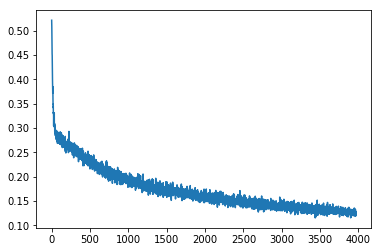

In [52]:
if __name__ == '__main__':

	#create the output image directory
	if (os.path.isdir('images')==0):
		os.mkdir('images')

	#choose dataset
	dataset_name = 'mnist'#

	#create AE model
	architecture = 'mlp'#'convolutional'#
	ae_mlp = autoencoder(dataset_name,architecture)#,

	ae_mlp.train(epochs=ae_mlp.epochs, batch_size=64, sample_interval=100)
	plt.plot(ae_mlp.error_list[30:])
	plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 7, 7, 4)           0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 196)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               19700     
__________

296 [Loss: 0.175762]
297 [Loss: 0.175761]
298 [Loss: 0.177841]
299 [Loss: 0.172588]
300 [Loss: 0.172218]
301 [Loss: 0.151857]
302 [Loss: 0.171654]
303 [Loss: 0.167670]
304 [Loss: 0.177306]
305 [Loss: 0.166491]
306 [Loss: 0.164377]
307 [Loss: 0.173612]
308 [Loss: 0.187555]
309 [Loss: 0.175176]
310 [Loss: 0.164301]
311 [Loss: 0.169884]
312 [Loss: 0.158645]
313 [Loss: 0.173720]
314 [Loss: 0.163740]
315 [Loss: 0.161269]
316 [Loss: 0.153046]
317 [Loss: 0.164683]
318 [Loss: 0.152851]
319 [Loss: 0.160881]
320 [Loss: 0.169923]
321 [Loss: 0.166568]
322 [Loss: 0.162644]
323 [Loss: 0.170061]
324 [Loss: 0.169789]
325 [Loss: 0.163346]
326 [Loss: 0.156496]
327 [Loss: 0.161077]
328 [Loss: 0.163365]
329 [Loss: 0.174164]
330 [Loss: 0.158823]
331 [Loss: 0.163772]
332 [Loss: 0.163603]
333 [Loss: 0.152751]
334 [Loss: 0.157010]
335 [Loss: 0.164553]
336 [Loss: 0.164762]
337 [Loss: 0.164827]
338 [Loss: 0.171668]
339 [Loss: 0.156742]
340 [Loss: 0.162813]
341 [Loss: 0.163983]
342 [Loss: 0.161460]
343 [Loss: 0.

698 [Loss: 0.125228]
699 [Loss: 0.135419]
700 [Loss: 0.131606]
701 [Loss: 0.127913]
702 [Loss: 0.129658]
703 [Loss: 0.122537]
704 [Loss: 0.128810]
705 [Loss: 0.128045]
706 [Loss: 0.130337]
707 [Loss: 0.117871]
708 [Loss: 0.129142]
709 [Loss: 0.124870]
710 [Loss: 0.133913]
711 [Loss: 0.130943]
712 [Loss: 0.132635]
713 [Loss: 0.133623]
714 [Loss: 0.142540]
715 [Loss: 0.142778]
716 [Loss: 0.130626]
717 [Loss: 0.129616]
718 [Loss: 0.128781]
719 [Loss: 0.127701]
720 [Loss: 0.138754]
721 [Loss: 0.124324]
722 [Loss: 0.128685]
723 [Loss: 0.140187]
724 [Loss: 0.135004]
725 [Loss: 0.131925]
726 [Loss: 0.127267]
727 [Loss: 0.121337]
728 [Loss: 0.125829]
729 [Loss: 0.130429]
730 [Loss: 0.140622]
731 [Loss: 0.143546]
732 [Loss: 0.128235]
733 [Loss: 0.132917]
734 [Loss: 0.123544]
735 [Loss: 0.128873]
736 [Loss: 0.127685]
737 [Loss: 0.133632]
738 [Loss: 0.122226]
739 [Loss: 0.119898]
740 [Loss: 0.127533]
741 [Loss: 0.121075]
742 [Loss: 0.124145]
743 [Loss: 0.129904]
744 [Loss: 0.126359]
745 [Loss: 0.

1099 [Loss: 0.113267]
1100 [Loss: 0.121796]
1101 [Loss: 0.112248]
1102 [Loss: 0.112917]
1103 [Loss: 0.130115]
1104 [Loss: 0.116124]
1105 [Loss: 0.118920]
1106 [Loss: 0.114725]
1107 [Loss: 0.109113]
1108 [Loss: 0.116612]
1109 [Loss: 0.117425]
1110 [Loss: 0.126944]
1111 [Loss: 0.124940]
1112 [Loss: 0.110811]
1113 [Loss: 0.118430]
1114 [Loss: 0.114660]
1115 [Loss: 0.120394]
1116 [Loss: 0.126745]
1117 [Loss: 0.120363]
1118 [Loss: 0.115874]
1119 [Loss: 0.115906]
1120 [Loss: 0.117961]
1121 [Loss: 0.111042]
1122 [Loss: 0.113833]
1123 [Loss: 0.114660]
1124 [Loss: 0.114053]
1125 [Loss: 0.121110]
1126 [Loss: 0.111478]
1127 [Loss: 0.119035]
1128 [Loss: 0.118699]
1129 [Loss: 0.118428]
1130 [Loss: 0.113666]
1131 [Loss: 0.113150]
1132 [Loss: 0.116831]
1133 [Loss: 0.115032]
1134 [Loss: 0.120156]
1135 [Loss: 0.116457]
1136 [Loss: 0.121065]
1137 [Loss: 0.117554]
1138 [Loss: 0.116339]
1139 [Loss: 0.120631]
1140 [Loss: 0.115503]
1141 [Loss: 0.108508]
1142 [Loss: 0.111138]
1143 [Loss: 0.116721]
1144 [Loss

1476 [Loss: 0.115937]
1477 [Loss: 0.116502]
1478 [Loss: 0.102824]
1479 [Loss: 0.113788]
1480 [Loss: 0.114495]
1481 [Loss: 0.109185]
1482 [Loss: 0.108112]
1483 [Loss: 0.107337]
1484 [Loss: 0.107419]
1485 [Loss: 0.108566]
1486 [Loss: 0.103731]
1487 [Loss: 0.110469]
1488 [Loss: 0.107582]
1489 [Loss: 0.106683]
1490 [Loss: 0.100942]
1491 [Loss: 0.104371]
1492 [Loss: 0.109781]
1493 [Loss: 0.104718]
1494 [Loss: 0.106734]
1495 [Loss: 0.106349]
1496 [Loss: 0.101583]
1497 [Loss: 0.099794]
1498 [Loss: 0.107389]
1499 [Loss: 0.105527]
1500 [Loss: 0.111191]
1501 [Loss: 0.108376]
1502 [Loss: 0.113384]
1503 [Loss: 0.108716]
1504 [Loss: 0.106548]
1505 [Loss: 0.107696]
1506 [Loss: 0.106963]
1507 [Loss: 0.103226]
1508 [Loss: 0.108281]
1509 [Loss: 0.104496]
1510 [Loss: 0.108214]
1511 [Loss: 0.108826]
1512 [Loss: 0.106851]
1513 [Loss: 0.119434]
1514 [Loss: 0.115091]
1515 [Loss: 0.110114]
1516 [Loss: 0.107554]
1517 [Loss: 0.112564]
1518 [Loss: 0.107253]
1519 [Loss: 0.104927]
1520 [Loss: 0.105250]
1521 [Loss

1849 [Loss: 0.098260]
1850 [Loss: 0.102976]
1851 [Loss: 0.097567]
1852 [Loss: 0.099043]
1853 [Loss: 0.103026]
1854 [Loss: 0.102825]
1855 [Loss: 0.102406]
1856 [Loss: 0.099752]
1857 [Loss: 0.106741]
1858 [Loss: 0.116904]
1859 [Loss: 0.107901]
1860 [Loss: 0.104293]
1861 [Loss: 0.106150]
1862 [Loss: 0.105923]
1863 [Loss: 0.106207]
1864 [Loss: 0.103184]
1865 [Loss: 0.101279]
1866 [Loss: 0.108295]
1867 [Loss: 0.110235]
1868 [Loss: 0.104553]
1869 [Loss: 0.095272]
1870 [Loss: 0.101080]
1871 [Loss: 0.100368]
1872 [Loss: 0.100539]
1873 [Loss: 0.105428]
1874 [Loss: 0.099845]
1875 [Loss: 0.099757]
1876 [Loss: 0.107932]
1877 [Loss: 0.103001]
1878 [Loss: 0.100839]
1879 [Loss: 0.109172]
1880 [Loss: 0.097056]
1881 [Loss: 0.104441]
1882 [Loss: 0.106293]
1883 [Loss: 0.100897]
1884 [Loss: 0.103442]
1885 [Loss: 0.105250]
1886 [Loss: 0.101976]
1887 [Loss: 0.096208]
1888 [Loss: 0.100270]
1889 [Loss: 0.102165]
1890 [Loss: 0.108957]
1891 [Loss: 0.102218]
1892 [Loss: 0.100224]
1893 [Loss: 0.103901]
1894 [Loss

2225 [Loss: 0.100544]
2226 [Loss: 0.104079]
2227 [Loss: 0.108714]
2228 [Loss: 0.101805]
2229 [Loss: 0.103179]
2230 [Loss: 0.100215]
2231 [Loss: 0.108365]
2232 [Loss: 0.108440]
2233 [Loss: 0.101893]
2234 [Loss: 0.103247]
2235 [Loss: 0.102488]
2236 [Loss: 0.096919]
2237 [Loss: 0.103002]
2238 [Loss: 0.108367]
2239 [Loss: 0.096639]
2240 [Loss: 0.101767]
2241 [Loss: 0.096670]
2242 [Loss: 0.095047]
2243 [Loss: 0.098805]
2244 [Loss: 0.096693]
2245 [Loss: 0.102555]
2246 [Loss: 0.102926]
2247 [Loss: 0.094559]
2248 [Loss: 0.099698]
2249 [Loss: 0.096779]
2250 [Loss: 0.103604]
2251 [Loss: 0.098885]
2252 [Loss: 0.099107]
2253 [Loss: 0.102415]
2254 [Loss: 0.099436]
2255 [Loss: 0.098435]
2256 [Loss: 0.101688]
2257 [Loss: 0.102761]
2258 [Loss: 0.100647]
2259 [Loss: 0.104845]
2260 [Loss: 0.098717]
2261 [Loss: 0.100288]
2262 [Loss: 0.098885]
2263 [Loss: 0.096543]
2264 [Loss: 0.106548]
2265 [Loss: 0.103460]
2266 [Loss: 0.104976]
2267 [Loss: 0.100070]
2268 [Loss: 0.097412]
2269 [Loss: 0.104453]
2270 [Loss

2599 [Loss: 0.098797]
2600 [Loss: 0.099169]
2601 [Loss: 0.096854]
2602 [Loss: 0.102289]
2603 [Loss: 0.103043]
2604 [Loss: 0.100830]
2605 [Loss: 0.098417]
2606 [Loss: 0.103238]
2607 [Loss: 0.099014]
2608 [Loss: 0.099559]
2609 [Loss: 0.100816]
2610 [Loss: 0.098785]
2611 [Loss: 0.095517]
2612 [Loss: 0.098302]
2613 [Loss: 0.098985]
2614 [Loss: 0.097986]
2615 [Loss: 0.101501]
2616 [Loss: 0.101522]
2617 [Loss: 0.102186]
2618 [Loss: 0.090959]
2619 [Loss: 0.093666]
2620 [Loss: 0.099284]
2621 [Loss: 0.094286]
2622 [Loss: 0.094155]
2623 [Loss: 0.099738]
2624 [Loss: 0.098743]
2625 [Loss: 0.105550]
2626 [Loss: 0.095100]
2627 [Loss: 0.101707]
2628 [Loss: 0.088887]
2629 [Loss: 0.099210]
2630 [Loss: 0.101064]
2631 [Loss: 0.097033]
2632 [Loss: 0.099014]
2633 [Loss: 0.105256]
2634 [Loss: 0.093334]
2635 [Loss: 0.094554]
2636 [Loss: 0.099187]
2637 [Loss: 0.096456]
2638 [Loss: 0.095615]
2639 [Loss: 0.094803]
2640 [Loss: 0.103120]
2641 [Loss: 0.101729]
2642 [Loss: 0.098310]
2643 [Loss: 0.095733]
2644 [Loss

2978 [Loss: 0.101094]
2979 [Loss: 0.096126]
2980 [Loss: 0.096415]
2981 [Loss: 0.093437]
2982 [Loss: 0.091709]
2983 [Loss: 0.094970]
2984 [Loss: 0.091047]
2985 [Loss: 0.093318]
2986 [Loss: 0.095861]
2987 [Loss: 0.088555]
2988 [Loss: 0.088598]
2989 [Loss: 0.096005]
2990 [Loss: 0.099772]
2991 [Loss: 0.096776]
2992 [Loss: 0.096118]
2993 [Loss: 0.097303]
2994 [Loss: 0.100839]
2995 [Loss: 0.091224]
2996 [Loss: 0.098480]
2997 [Loss: 0.097321]
2998 [Loss: 0.097830]
2999 [Loss: 0.099260]
3000 [Loss: 0.098280]
3001 [Loss: 0.092412]
3002 [Loss: 0.092850]
3003 [Loss: 0.095777]
3004 [Loss: 0.096238]
3005 [Loss: 0.099124]
3006 [Loss: 0.094268]
3007 [Loss: 0.097802]
3008 [Loss: 0.091880]
3009 [Loss: 0.088796]
3010 [Loss: 0.098985]
3011 [Loss: 0.095231]
3012 [Loss: 0.098590]
3013 [Loss: 0.099127]
3014 [Loss: 0.093845]
3015 [Loss: 0.096544]
3016 [Loss: 0.097511]
3017 [Loss: 0.096726]
3018 [Loss: 0.096843]
3019 [Loss: 0.092672]
3020 [Loss: 0.091941]
3021 [Loss: 0.093273]
3022 [Loss: 0.093265]
3023 [Loss

3374 [Loss: 0.092538]
3375 [Loss: 0.090979]
3376 [Loss: 0.095440]
3377 [Loss: 0.100972]
3378 [Loss: 0.098676]
3379 [Loss: 0.098397]
3380 [Loss: 0.103408]
3381 [Loss: 0.087404]
3382 [Loss: 0.100004]
3383 [Loss: 0.093074]
3384 [Loss: 0.098001]
3385 [Loss: 0.089874]
3386 [Loss: 0.096827]
3387 [Loss: 0.094133]
3388 [Loss: 0.091455]
3389 [Loss: 0.091591]
3390 [Loss: 0.095282]
3391 [Loss: 0.097653]
3392 [Loss: 0.101372]
3393 [Loss: 0.102443]
3394 [Loss: 0.094639]
3395 [Loss: 0.092788]
3396 [Loss: 0.092580]
3397 [Loss: 0.093613]
3398 [Loss: 0.096135]
3399 [Loss: 0.097405]
3400 [Loss: 0.089558]
3401 [Loss: 0.097715]
3402 [Loss: 0.097950]
3403 [Loss: 0.096074]
3404 [Loss: 0.095933]
3405 [Loss: 0.089527]
3406 [Loss: 0.092208]
3407 [Loss: 0.088594]
3408 [Loss: 0.092033]
3409 [Loss: 0.095026]
3410 [Loss: 0.087054]
3411 [Loss: 0.098846]
3412 [Loss: 0.097120]
3413 [Loss: 0.093962]
3414 [Loss: 0.085827]
3415 [Loss: 0.096126]
3416 [Loss: 0.091615]
3417 [Loss: 0.095609]
3418 [Loss: 0.089811]
3419 [Loss

3750 [Loss: 0.098625]
3751 [Loss: 0.093548]
3752 [Loss: 0.096307]
3753 [Loss: 0.090475]
3754 [Loss: 0.092152]
3755 [Loss: 0.093589]
3756 [Loss: 0.091540]
3757 [Loss: 0.091773]
3758 [Loss: 0.093663]
3759 [Loss: 0.098386]
3760 [Loss: 0.100632]
3761 [Loss: 0.097403]
3762 [Loss: 0.097586]
3763 [Loss: 0.090805]
3764 [Loss: 0.093120]
3765 [Loss: 0.087779]
3766 [Loss: 0.093961]
3767 [Loss: 0.089667]
3768 [Loss: 0.091582]
3769 [Loss: 0.092321]
3770 [Loss: 0.088732]
3771 [Loss: 0.090907]
3772 [Loss: 0.089068]
3773 [Loss: 0.089825]
3774 [Loss: 0.090729]
3775 [Loss: 0.090656]
3776 [Loss: 0.094670]
3777 [Loss: 0.091684]
3778 [Loss: 0.092186]
3779 [Loss: 0.093261]
3780 [Loss: 0.098761]
3781 [Loss: 0.095284]
3782 [Loss: 0.093712]
3783 [Loss: 0.088744]
3784 [Loss: 0.094542]
3785 [Loss: 0.088712]
3786 [Loss: 0.090211]
3787 [Loss: 0.093039]
3788 [Loss: 0.084348]
3789 [Loss: 0.092403]
3790 [Loss: 0.087948]
3791 [Loss: 0.097174]
3792 [Loss: 0.088599]
3793 [Loss: 0.091464]
3794 [Loss: 0.089950]
3795 [Loss

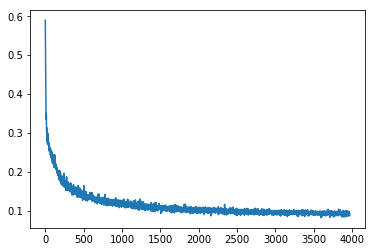

In [53]:
if __name__ == '__main__':

	#create the output image directory
	if (os.path.isdir('images')==0):
		os.mkdir('images')

	#choose dataset
	dataset_name = 'mnist'#

	#create AE model
	architecture = 'convolutional'#'mlp'#'convolutional'#
	ae_conv = autoencoder(dataset_name,architecture)#,

	ae_conv.train(epochs=ae_conv.epochs, batch_size=64, sample_interval=100)
	plt.plot(ae_conv.error_list[30:])
	plt.show()

In [54]:
n_images = 5
(X_train, _), (_, _) = mnist.load_data()
X_train = np.expand_dims(X_train, axis=3)
X_train = X_train/255.0
noise = np.expand_dims(np.random.normal(scale=20/255, size=(n_images,X_train.shape[1],X_train.shape[2])),
                                   axis=3)
idx = np.random.randint(0, X_train.shape[0], n_images)
test_imgs = X_train[idx,:,:,:] + noise
n_images = test_imgs.shape[0]
ae_mlp, ae_conv = load_model('ae_mlp.h5'), load_model('ae_convolutional.h5')
output_imgs1 = ae_mlp.predict(test_imgs)
output_imgs2 = ae_conv.predict(test_imgs)

In [ ]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z10.eps', bbox_inches='tight')
plt.show()

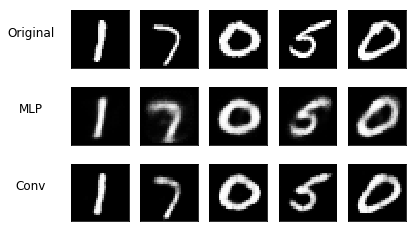

In [22]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z100.eps', bbox_inches='tight')
plt.show()

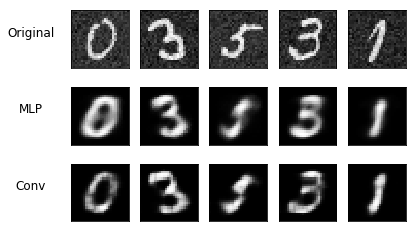

In [50]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z10_noisy.eps', bbox_inches='tight')
plt.show()

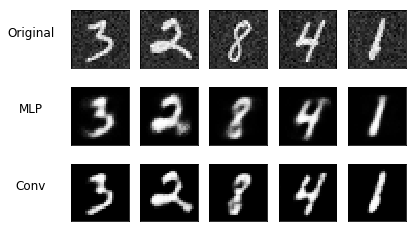

In [55]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 40 
r = 3
c = n_images
fig, axs = plt.subplots(r, c)
#fig.set_figheight(15)
#fig.set_figwidth(15)
for j in range(c):
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])
    axs[1,j].imshow(output_imgs1[j, :,:,0], cmap='gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_yticks([])
    axs[2,j].imshow(output_imgs2[j, :,:,0], cmap='gray')
    axs[2,j].set_xticks([])
    axs[2,j].set_yticks([])

axs[0,0].set_ylabel('Original', rotation=0, size='large')
axs[1,0].set_ylabel('MLP', rotation=0, size='large')
axs[2,0].set_ylabel('Conv', rotation=0, size='large')

#fig.tight_layout()
plt.savefig('results_z100_noisy.eps', bbox_inches='tight')
plt.show()

In [ ]:
class variational_autoencoder():
    def __init__(self,dataset_name='mnist',architecture='mlp'):
        
        X_train = self.load_data(dataset_name)
        optimizer = 'adadelta'#Adam(0.0002, 0.5) #

        # image parameters
        self.epochs = 30000
        self.error_list = np.zeros((self.epochs,1))
        self.img_rows = X_train.shape[1]
        self.img_cols = X_train.shape[2]
        self.img_channels = X_train.shape[3]
        self.img_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
        self.z_dim = 10
        self.architecture = architecture
        self.dataset_name = dataset_name

        # Build and compile the discriminator
        self.vae = self.build_vae()
        self.vae.summary()

    def build_vae(self):

        n_pixels = self.img_rows*self.img_cols*self.img_channels

        #BEGIN INSERT CODE
        #encoder
        input_img = ...
        z = ...
        # mean and variance parameters
        z_mean = ...
        z_log_var = ...

        #sample the latent vector
        z_rand = Lambda(sampling, output_shape=(self.z_dim,))([z_mean, z_log_var])
        #save the encoder
        self.encoder = Model(input_img, [z_mean, z_log_var, z_rand], name='encoder')

        #build decoder
        latent_inputs = Input(shape=(self.z_dim,), name='z_sampling')
        y = Dense(512)(latent_inputs)
        output_img = ...
        self.decoder = Model(latent_inputs, output_img, name='decoder')

        #build encoder + decoder (total model)
        output_img = self.decoder(self.encoder(input_img)[2])
        vae = Model(input_img, output_img, name='vae_mlp')

        #create the total model
        vae = Model(input_img,output_img)
        #define the loss
        vae_loss = self.vae_loss(input_img_flatten, output_img,z_mean,z_log_var)
        vae.add_loss(vae_loss)
        vae.compile(optimizer='adam')

        return vae

    def vae_loss(self,x,y,z_mean,z_log_var):
        # BEGIN INSERT CODE

        # reconstruction loss
        reconstruction_loss = ...
        # KL divergence
        kl_loss = ...
        # total loss
        vae_loss = ...

        # END FILL IN CODE
        return vae_loss

    def sampling(self,args):
        #Reparameterization trick
        z_mean, z_log_var = args
        batch_size = K.shape(z_mean)[0]
        # sample random vector of size (batch_size,z_dim)
        epsilon = K.random_normal(shape=(batch_size,self.z_dim))
        z_sigma = K.exp(0.5 * z_log_var)
        z_epsilon = Multiply()([z_sigma,epsilon])
        z_rand = Add()([z_mean,z_epsilon])
        return z_rand

    def load_data(self,dataset_name):
        # Load the dataset
        if(dataset_name == 'mnist'):
            (X_train, _), (_, _) = mnist.load_data()
        else:
            print('Error, unknown database')

        # normalise images between 0 and 1
        X_train = X_train/255.0
        #add a channel dimension, if need be (for mnist data)
        if(X_train.ndim ==3):
            X_train = np.expand_dims(X_train, axis=3)
        return X_train

    def train(self, epochs, batch_size=128, sample_interval=50):
        
        #load dataset
        X_train = self.load_data(self.dataset_name)

        for i in range(0,epochs):

            # ---------------------
            #  Train variational autoencoder
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            curr_batch = X_train[idx,:,:,:]
            # Autoencoder training
            loss = self.vae.train_on_batch(curr_batch,None)

            # print the losses
            print("%d [Loss: %f]" % (i, loss))
            self.error_list[i] = loss

            # Save some random generated images and the models at every sample_interval iterations
            if (i % sample_interval == 0):
                n_images = 5
                idx = np.random.randint(0, X_train.shape[0], n_images)
                test_imgs = X_train[idx,:,:,:]
                self.reconstruct_images(test_imgs,'images/'+self.dataset_name+'_reconstruction_%06d.png' % i)
                self.sample_images('images/'+self.dataset_name+'_random_samples_%06d.png' % i)

    def reconstruct_images(self, test_imgs, image_filename):
        n_images = test_imgs.shape[0]
        #get output images
        output_imgs = np.reshape(self.vae.predict( test_imgs ),(n_images,self.img_rows,self.img_cols,self.img_channels))
        r = 2
        c = n_images
        fig, axs = plt.subplots(r, c)
        for j in range(c):
            #black and white images
            axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
            axs[0,j].axis('off')
            axs[1,j].imshow(output_imgs[j, :,:,0], cmap='gray')
            axs[1,j].axis('off')
        fig.savefig(image_filename)
        plt.close()

    def sample_images(self, image_filename):

        n_images = 8    #number of random images to sample
        #get output images
        z_sample = np.random.normal(0,1,(n_images,self.z_dim))
        r = 1
        c = n_images
        fig, axs = plt.subplots(r, c)
        for j in range(c):
            x_decoded = np.reshape(self.decoder.predict(z_sample) , (n_images,self.img_rows,self.img_cols,self.img_channels))
            #black and white images
            axs[j].imshow(x_decoded[j, :,:,0], cmap='gray')
            axs[j].axis('off')
        fig.savefig(image_filename)
        plt.close()
